## Load the dataset

In [1]:
import pandas as pd
import numpy as np
import torch
from pytorch_tabular.categorical_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42
FILENAME = "dataset/train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)


# remove label columns
# df1 = df1.drop(["label"], axis=1)

# mapping ={ "T": 1, "F": 0, "-": np.nan}
# df1 = df1.map(lambda x: mapping.get(x, x))

# get features names
features = list(df1.columns)

# count = df1.count()
# threshold = count.quantile(0.25)
# print(f"soglia : {threshold}")

# df1 = df1.loc[:, count >= threshold]
# features_to_remove = list(count[count <= threshold].index)

features_to_remove = ["label", "ts", "src_ip", "dst_ip", "dns_query", "ssl_subject", "ssl_issuer", "http_uri", "type", "http_referrer"]

# features_to_remove = [ 'http_trans_depth', 'http_resp_mime_types', 'ssl_cipher', 'dns_query', 'http_version', 'http_user_agent', 'http_uri', 'weird_notice', 'ssl_established', 'weird_addl', 'http_method', 'ssl_resumed', "src_ip", "dst_ip", "type"]
for feature in features_to_remove:
    features.remove(feature)

df1 = df1[features + ["type"]]

# Conversion of datatype

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')
# Filtra le righe con NaN (valori non convertibili)
df1 = df1.dropna(subset=["src_bytes"])
# Converte i valori rimasti in interi
df1.loc[:, "src_bytes"] = df1["src_bytes"].astype(int)

print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))
df1 = df1.dropna()
print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

X = df1[features]
y = df1["type"]

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

indices = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y[train_idx], random_state=seed)


fold = np.zeros(X.shape[0])
fold[train_idx] = -1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# for i, (train_index, test_index) in enumerate(ps.split()):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

# take only x with index in val_idx
X_val = X.iloc[val_idx]
y_val = y[val_idx]
X_train = X.iloc[train_idx]
y_train = y[train_idx]

X_test = X.iloc[test_idx]
y_test = y[test_idx]

#Righe: 616983 #Colonne: 37
#Righe: 616983 #Colonne: 37


In [2]:
df1

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,type
0,53972,10502,tcp,-,0.000000,0.0,0,OTH,0,0,...,0,0,0,-,-,-,-,-,-,normal
1,37513,53,udp,dns,0.163608,47.0,423,SF,0,1,...,0,0,0,-,-,-,-,-,-,normal
2,2077,2077,tcp,-,0.208218,0.0,0,S0,0,120,...,0,0,0,-,-,-,-,-,-,normal
3,53972,10502,tcp,-,0.000000,0.0,0,OTH,0,0,...,0,0,0,-,-,-,-,-,-,normal
4,1880,47979,tcp,-,0.000000,0.0,0,OTH,0,1,...,0,0,0,-,-,-,-,-,-,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616997,53116,53,udp,dns,0.044893,84.0,424,SF,0,2,...,0,0,0,-,-,-,-,-,-,mitm
616998,57669,53,udp,dns,0.002957,84.0,436,SF,0,2,...,0,0,0,-,-,-,-,-,-,mitm
616999,54730,53,udp,dns,0.016624,58.0,178,SF,0,2,...,0,0,0,-,-,-,-,-,-,mitm
617000,59846,443,tcp,ssl,48.271568,3219.0,1212,SF,0,26,...,0,0,0,-,-,-,-,-,-,mitm


In [3]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# undersampler = RandomUnderSampler(random_state=seed)
# X_train, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
# smote = SMOTENC(categorical_features=categorical_columns, random_state=seed)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


## Preprocess the dataset

In [3]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import KNNImputer, SimpleImputer

import pickle


#categorical_columns = ["proto", "service", "conn_state"]
#boolean_columns= [ "dns_AA", "dns_RD", "dns_RA", "dns_rejected"]

categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
# boolean_columns = X_train.select_dtypes(include=["bool"]).columns.tolist()

ct = ColumnTransformer(
    [
        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),  # Trasforma le colonne categoriche
        # ("scale", StandardScaler(), ["feature1", "feature2"])  # Normalizza le colonne numeriche
    ],
    remainder="passthrough"  # Mantieni le altre colonne invariate
)
ct.set_output(transform="pandas")

ct = ct.fit(X_train)
with open("transformer.save", "wb") as f:
    pickle.dump(ct, f)

# train set
X_train = ct.transform(X_train)

# validation set
X_val = ct.transform(X_val)

# X
X = ct.transform(X)

# X_test
X_test = ct.transform(X_test)

# # train set
# ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# ordinal_encoder = ordinal_encoder.fit(X_train[categorical_columns])
# X_train.loc[:, categorical_columns] = ordinal_encoder.transform(X_train[categorical_columns])
#
# # validation set
# X_val.loc[:, categorical_columns] = ordinal_encoder.transform(X_val[categorical_columns])
#
# # X
# X.loc[:, categorical_columns] = ordinal_encoder.transform(X[categorical_columns])
#
# X_test.loc[:, categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns])

In [23]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=20)
pca.set_output(transform="pandas")

pca.fit(X_train)

X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X = pca.transform(X)
X_test = pca.transform(X_test)

## Apply K-Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

knn = KNeighborsClassifier().fit(X_train, y_train)
print("Performance:", knn.score(X_val, y_val))
with open( "knn.save", "wb") as file:
    pickle.dump(knn, file)

D:\DataAnalyticsProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\DataAnalyticsProject\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wi

## Apply Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf = RandomForestClassifier(random_state=seed, class_weight="balanced").fit(X_train, y_train)
print("Performance:", rf.score(X_val, y_val))
with open( "rf.save", "wb") as file:
    pickle.dump(rf, file)

Performance: 0.9949249377013311


## Apply Support Vector Classifier with HP tuning

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# param_grid = {'C': [0.1],  #, 1, 10, 100, 1000],
#               'gamma': [1],  #, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ["linear"]}  #, "poly", "rbf", "sigmoid"]}
#
# grid = RandomizedSearchCV(SVC(random_state=seed), param_grid, cv=ps)
# grid.fit(X, y)
svc = SVC(random_state=seed, class_weight="balanced").fit(X_train, y_train)
print("Performance:", svc.score(X_val, y_val))
with open("svc.save", "wb") as file:
    pickle.dump(svc, file)

# print("Best hyperparameters: ", grid.best_estimator_)
# print("Best performance:", grid.best_score_)


In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix


def predict(X, y, clf):
    # X = data[:, :-1]
    # y = data[:, -1]

    ypred = clf.predict(X)
    acc = accuracy_score(y, ypred)
    bacc = balanced_accuracy_score(y, ypred)
    f1 = f1_score(y, ypred, average="weighted")
    print(confusion_matrix(y, ypred))

    perf = {"acc": acc, "bacc": bacc, "f1": f1}

    return perf


predict(X_test, y_test, rf)

[[ 3030     0     1     0     0     0     0     0     1     0]
 [    0 36348    12    13     2     5    47     0    20    50]
 [    0     5 10848     9     5     2     4     0    22     1]
 [    0    19     4  2601     5     1    11     0     6    69]
 [    0     2     3     4   102     5     5     0     2     2]
 [    0     9     1     0    10  4082     1     7    14     8]
 [    0    44     2     7     4     2 10234     0     0    18]
 [    0     2     0     0     0     1     0   190     0     0]
 [    2     8    15    10     5    15     2     2 42771    11]
 [    0    45     3    16     5     3    12     0     5 12565]]


{'acc': 0.9949269431185523,
 'bacc': 0.9720731106878915,
 'f1': 0.9949340762270686}

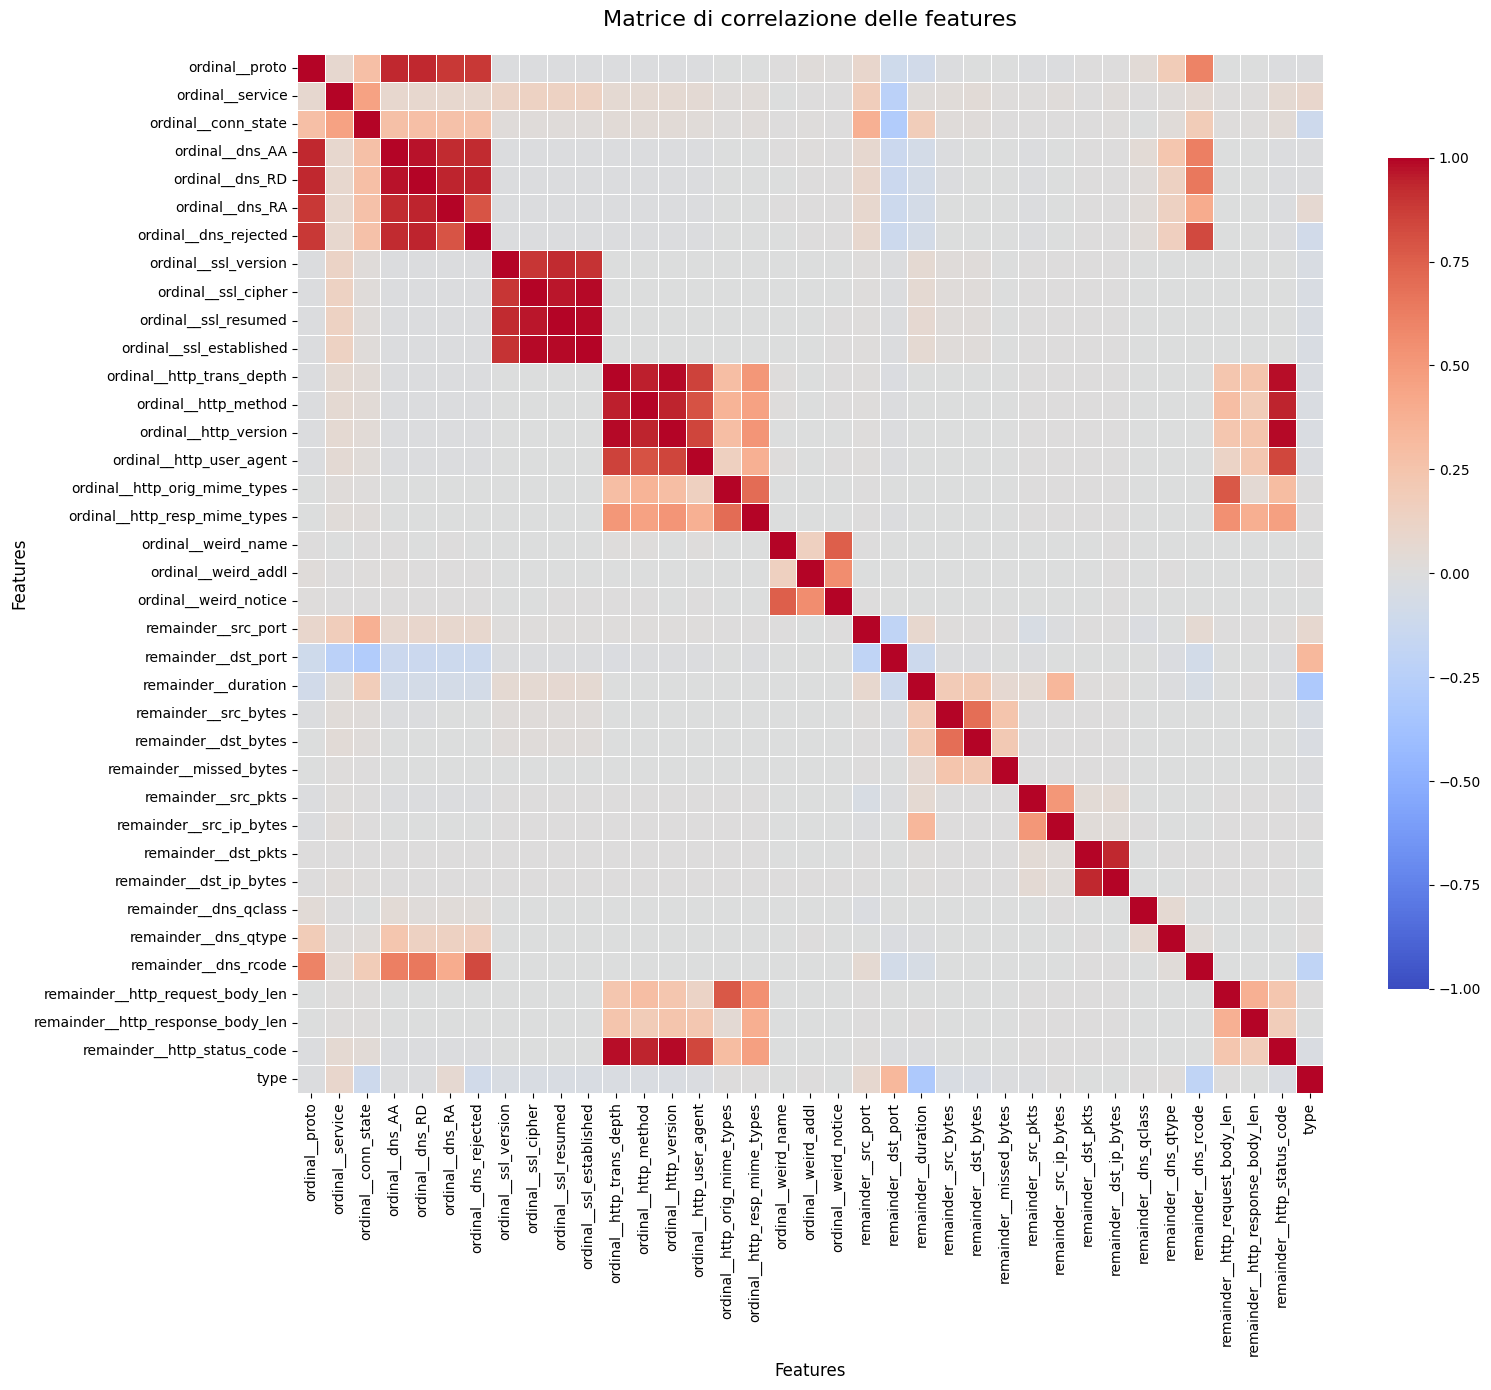

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# add column y to dataframe X

df = pd.concat([X, pd.DataFrame(y, columns=["type"])], axis=1)
correlation_matrix = df.corr()


plt.figure(figsize=(16, 14))

# Crea una heatmap della matrice di correlazione senza annotazioni
sns.heatmap(
    correlation_matrix,
    annot=False,  # annotazioni numeriche
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.8}
)

plt.title('Matrice di correlazione delle features', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()